In [1]:
import pandas as pd
import numpy as np
import pickle
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin

from interpret.glassbox import ExplainableBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli 
from snapml import BoostingMachineClassifier  
from pytorch_tabnet.tab_model import TabNetClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from skorch import NeuralNetClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer 
from tab_transformer_pytorch import FTTransformer

2025-04-19 11:29:27.736523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745036967.753834   21339 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745036967.759277   21339 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 11:29:27.778389: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('data/cleaned_data.csv')
cols_to_keep = ['age', 
                'height',
                'weight',
                'systolic', 
                'diastolic',
                'gender',
                'cholesterol', 
                'gluc',
                'smoke', 
                'alco', 
                'active',
                'cardio'
                ]

df = df[cols_to_keep]

In [3]:
X = df.drop('cardio', axis=1)
y = df['cardio']

label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic']
ordinal_features = ['cholesterol', 'gluc']
binary_features = ['gender', 'smoke', 'alco', 'active']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Catatan: ColumnTransformer dengan remainder='passthrough' akan mengubah urutan kolom.
# Fitur yang discaling akan berada di awal, kemudian sisanya.
# Untuk mendapatkan nama kolom kembali (opsional), kita bisa menyusun ulang nama kolom sebagai berikut.
passthrough_features = [col for col in X.columns if col not in numerical_features]
transformed_feature_names = numerical_features + passthrough_features

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)
print("Contoh data train setelah scaling:")
print(X_train_transformed_df.head())

Contoh data train setelah scaling:
        age    height    weight  systolic  diastolic  gender  cholesterol  \
0 -0.431181 -0.580958  0.227592 -0.448449  -0.219513     0.0          0.0   
1  1.645896 -0.050963  0.146374 -0.448449  -1.522162     0.0          0.0   
2 -1.766444  0.479031 -0.503370 -1.149304  -1.522162     0.0          0.0   
3 -1.469719  0.611530  1.933169  1.303690   1.734461     1.0          0.0   
4 -0.134455  1.009026  0.146374 -0.448449  -0.219513     0.0          0.0   

   gluc  smoke  alco  active  
0   0.0    0.0   0.0     0.0  
1   0.0    0.0   0.0     0.0  
2   0.0    0.0   0.0     1.0  
3   0.0    1.0   1.0     1.0  
4   0.0    0.0   0.0     1.0  


In [4]:
x_train_np = np.array(X_train_transformed)
y_train_np = np.array(y_train)
x_test_np = np.array(X_test_transformed)
y_test_np = np.array(y_test)

In [5]:
class TabularDataset(Dataset):
    def __init__(self, X, categorical_indices, continuous_indices, targets):
        self.X = X
        self.categorical_indices = categorical_indices
        self.continuous_indices = continuous_indices
        self.targets = targets
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        row = self.X[idx]
        x_cont = row[self.continuous_indices].astype(np.float32)
        x_cat  = row[self.categorical_indices].astype(np.int64)
        target = np.array(self.targets[idx]).astype(np.float32)
        return x_cat, x_cont, target

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, epochs=10, lr=1e-3, batch_size=32, device=None,
                continuous_indices=None, categorical_indices=None, classes_=None):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.continuous_indices = continuous_indices
        self.categorical_indices = categorical_indices
        self.classes_ = classes_ if classes_ is not None else []
    
    def fit(self, X, y):
        if self.continuous_indices is None or self.categorical_indices is None:
            raise ValueError("continuous_indices and categorical_indices must be provided")
        train_dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, y)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.model.to(self.device)
        self.model.train()
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch in train_loader:
                x_cat, x_cont, targets = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                targets = targets.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(x_cat, x_cont)
                loss = criterion(outputs, targets.float().unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
            print(f"[Wrapper] Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        preds = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                preds.append((probs.cpu().numpy() >= 0.5).astype(int))
        preds = np.concatenate(preds).squeeze()
        return preds

    def predict_proba(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        probas = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                probas.append(probs.cpu().numpy())
        probas = np.concatenate(probas).squeeze()
        return np.vstack([1 - probas, probas]).T

    def get_params(self, deep=True):
        return {
            "model": self.model,
            "epochs": self.epochs,
            "lr": self.lr,
            "batch_size": self.batch_size,
            "device": self.device,
            "continuous_indices": self.continuous_indices,
            "categorical_indices": self.categorical_indices,
            "classes_": self.classes_
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [6]:
def evaluate_model(model, model_name="", framework="", 
                   x_train=None, y_train=None, x_test=None, y_test=None,
                   continuous_indices=None, categorical_indices=None,
                   batch_size=32, device=None, epochs=10, **kwargs):

    if framework.lower() not in ["tab transformer", "ft transformer"]:
        if x_train is None or y_train is None or x_test is None or y_test is None:
            raise ValueError("Incomplete parameters. Provide x_train, y_train, x_test, y_test for scikit-learn evaluation.")

        model.fit(x_train, y_train)
        
        y_pred_test = model.predict(x_test)
        y_proba_test = model.predict_proba(x_test)
        y_probs_test = y_proba_test[:, 1] if y_proba_test.ndim > 1 and y_proba_test.shape[1] > 1 else y_proba_test[:, 0]
        
        y_pred_train = model.predict(x_train)
        y_proba_train = model.predict_proba(x_train)
        y_probs_train = y_proba_train[:, 1] if y_proba_train.ndim > 1 and y_proba_train.shape[1] > 1 else y_proba_train[:, 0]
        
        test_accuracy  = accuracy_score(y_test, y_pred_test)
        test_auc       = roc_auc_score(y_test, y_probs_test)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        train_auc      = roc_auc_score(y_train, y_probs_train)
        
        test_report_dict = classification_report(y_test, y_pred_test, output_dict=True)
        test_precision = test_report_dict['weighted avg']['precision']
        test_recall    = test_report_dict['weighted avg']['recall']
        test_f1        = test_report_dict['weighted avg']['f1-score']
        
        train_report_dict = classification_report(y_train, y_pred_train, output_dict=True)
        train_precision = train_report_dict['weighted avg']['precision']
        train_recall    = train_report_dict['weighted avg']['recall']
        train_f1        = train_report_dict['weighted avg']['f1-score']
    
    elif framework.lower() in ["tab transformer", "ft transformer"]:
        train_loader = kwargs.get("train_loader")
        test_loader  = kwargs.get("test_loader")
        
        if train_loader is None or test_loader is None:
            if x_train is None or y_train is None or x_test is None or y_test is None:
                raise ValueError("Incomplete parameters. Provide either train_loader, test_loader, device or raw x_train, y_train, x_test, y_test along with index information.")
            
            if continuous_indices is None:
                continuous_indices = list(range(len(numerical_features)))
            if categorical_indices is None:
                categorical_indices = list(range(len(numerical_features), len(transformed_feature_names)))
            if device is None:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            train_dataset = TabularDataset(x_train, categorical_indices, continuous_indices, y_train)
            test_dataset  = TabularDataset(x_test, categorical_indices, continuous_indices, y_test)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        model.to(device)
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        model.train()
        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch in train_loader:
                x_cat, x_cont, targets = batch
                x_cat, x_cont, targets = x_cat.to(device), x_cont.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(x_cat, x_cont)
                loss = criterion(outputs, targets.float().unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_epoch_loss = epoch_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_epoch_loss:.4f}")
        
        model.eval()
        all_preds_test, all_targets_test, test_losses = [], [], []
        with torch.no_grad():
            for batch in test_loader:
                x_cat, x_cont, targets = batch
                x_cat, x_cont, targets = x_cat.to(device), x_cont.to(device), targets.to(device)
                outputs = model(x_cat, x_cont)
                loss = criterion(outputs, targets.float().unsqueeze(1))
                test_losses.append(loss.item())
                probs = torch.sigmoid(outputs)
                all_preds_test.append(probs.cpu().numpy())
                all_targets_test.append(targets.cpu().numpy())
        avg_test_loss = np.mean(test_losses)
        all_preds_test   = np.concatenate(all_preds_test).squeeze()
        all_targets_test = np.concatenate(all_targets_test).squeeze()
        y_pred_test = (all_preds_test >= 0.5).astype(int)
        
        test_accuracy  = accuracy_score(all_targets_test, y_pred_test)
        test_auc       = roc_auc_score(all_targets_test, all_preds_test)
        
        test_report_dict = classification_report(all_targets_test, y_pred_test, output_dict=True)
        test_precision = test_report_dict['weighted avg']['precision']
        test_recall    = test_report_dict['weighted avg']['recall']
        test_f1        = test_report_dict['weighted avg']['f1-score']
        
        all_preds_train, all_targets_train = [], []
        with torch.no_grad():
            for batch in train_loader:
                x_cat, x_cont, targets = batch
                x_cat, x_cont = x_cat.to(device), x_cont.to(device)
                outputs = model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                all_preds_train.append(probs.cpu().numpy())
                all_targets_train.append(targets.cpu().numpy())
        all_preds_train   = np.concatenate(all_preds_train).squeeze()
        all_targets_train = np.concatenate(all_targets_train).squeeze()
        y_pred_train = (all_preds_train >= 0.5).astype(int)
        train_accuracy = accuracy_score(all_targets_train, y_pred_train)
        train_auc      = roc_auc_score(all_targets_train, all_preds_train)
        
        train_report_dict = classification_report(all_targets_train, y_pred_train, output_dict=True)
        train_precision = train_report_dict['weighted avg']['precision']
        train_recall    = train_report_dict['weighted avg']['recall']
        train_f1        = train_report_dict['weighted avg']['f1-score']
        
    else:
        raise ValueError("Framework harus 'ml' atau 'dl'.")
    
    data = [
        ["Test", f"{int(test_accuracy * 100 * 100) / 100:.2f}%", f"{test_auc:.4f}"],
        ["Train", f"{int(train_accuracy * 100 * 100) / 100:.2f}%", f"{train_auc:.4f}"]
    ]
    headers = ["", "Accuracy", "AUC Score"]
    
    print(f"\n=== {model_name} ===\n")
    print(tabulate(data, headers=headers, tablefmt="grid"))
    print("\nOverfitting Check :")
    if train_accuracy > test_accuracy + 0.05 or train_auc > test_auc + 0.05:
        print("The model might be overfitting.")
    else:
        print("No significant signs of overfitting.\n")
    
    return {
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'train_precision': train_precision,
        'train_recall': train_recall,
        'train_f1': train_f1,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1
    }
    
def create_summary_table(results):
    test_summary = pd.DataFrame([{
        'Algorithm': r['model_name'],
        'Accuracy':  round(r['test_accuracy'], 4),
        'Precision': round(r['test_precision'], 4),
        'Recall':    round(r['test_recall'], 4),
        'F1-Score':  round(r['test_f1'], 4)
    } for r in results])
    
    train_summary = pd.DataFrame([{
        'Algorithm': r['model_name'],
        'Accuracy':  round(r['train_accuracy'], 4),
        'Precision': round(r['train_precision'], 4),
        'Recall':    round(r['train_recall'], 4),
        'F1-Score':  round(r['train_f1'], 4)
    } for r in results])
    
    print("\nSummary Table - Test Metrics")
    print(tabulate(test_summary, headers='keys', tablefmt='grid', showindex=False))

    print("\nSummary Table - Training Metrics")
    print(tabulate(train_summary, headers='keys', tablefmt='grid', showindex=False))


In [7]:
best_params = {
    'n_estimators': 233,
    'learning_rate': 0.019519792757748358,
    'num_leaves': 41,
    'max_depth': 15,
    'subsample': 0.758484089588373,
    'colsample_bytree': 0.9592852139230149,
    'random_state': 6580,
    'verbose' : -1
}

lgbm_model = LGBMClassifier(verbose=-1)

lgbm_results = evaluate_model(
    model=lgbm_model, 
    model_name="LightGBM", 
    framework="ml",
    x_train=x_train_np, 
    y_train=y_train, 
    x_test=x_test_np, 
    y_test=y_test
)

lgbm_results;

# original --> 74.06%
# bmi --> 73.87%
# bmi, pp --> 74.05%
# bmi, pp, map --> 73.81%
# pp --> 74.13%
# pp, map --> 73.81%
# map --> 73.97%
# map, bmi --> 74.03%


=== LightGBM ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 74.06%     |      0.8014 |
+-------+------------+-------------+
| Train | 74.18%     |      0.8157 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.740661
Test AUC: 0.801362

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7266    0.7809    0.7528      6321
           1     0.7574    0.6995    0.7273      6180

    accuracy                         0.7407     12501
   macro avg     0.7420    0.7402    0.7400     12501
weighted avg     0.7418    0.7407    0.7402     12501


Train Accuracy: 0.741865
Train AUC: 0.815651

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7262    0.7868    0.7553     25313
           1     0.7610    0.6958    0.7269     24688

    accuracy                         0.7419     50001
   macro avg     0.7436    0.7413    0.7411     50001
weighted avg     0.7433    0.7419    0.7413     50001

No significant signs of overfitting.



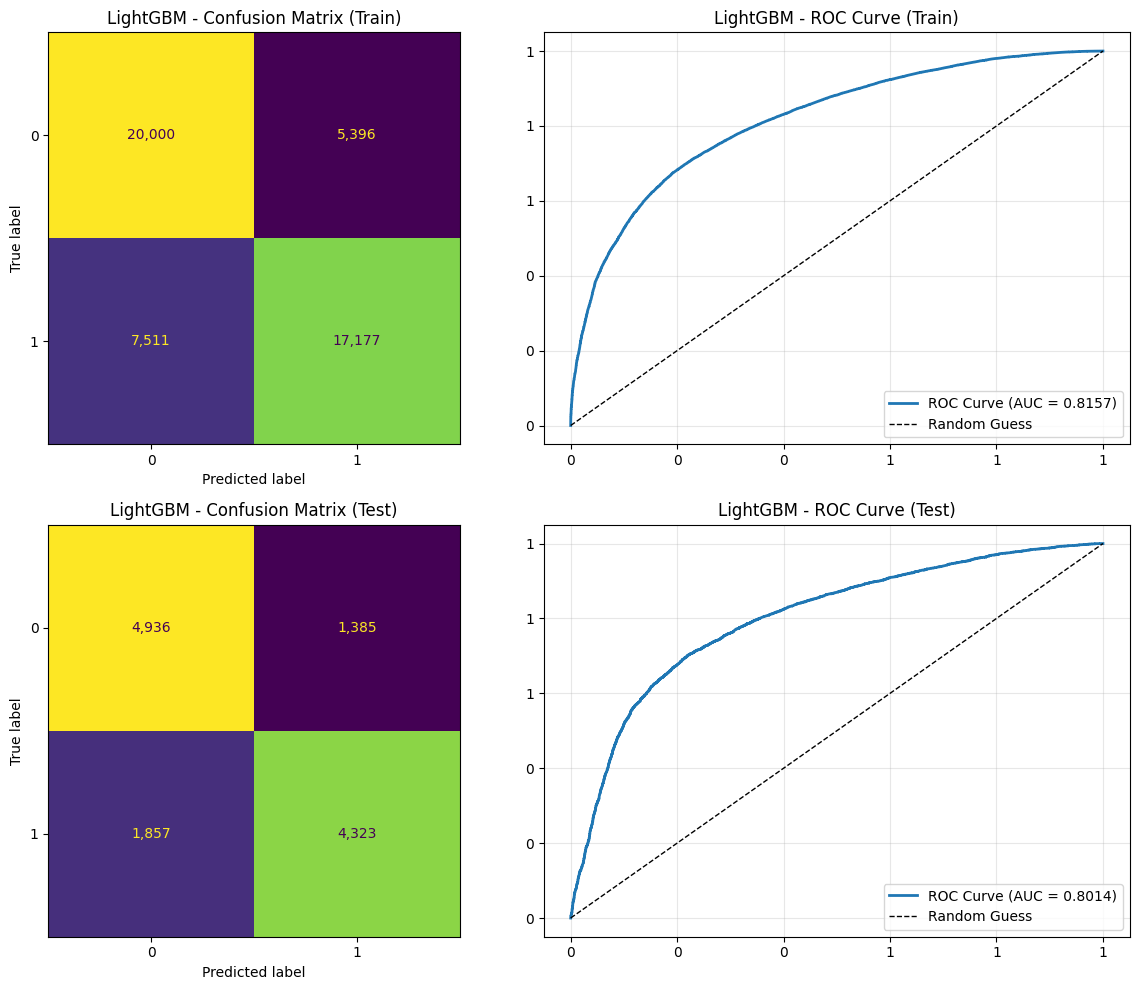

In [8]:
algorithm_name = 'LightGBM'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = lgbm_model.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = lgbm_model.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = lgbm_model.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = lgbm_model.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [9]:
# best_params = {
#     'iterations': 680, 
#     'learning_rate': 0.01040286438048717, 
#     'depth': 9, 
#     'l2_leaf_reg': 0.10424693387826892, 
#     'border_count': 220, 
#     'random_strength': 0.015513247584661348, 
#     'bagging_temperature': 0.2020691195100053, 
#     'random_seed': 7801,
#     'verbose': False
#     }

catb_model = CatBoostClassifier(verbose=False)
catb_results = evaluate_model(
    model= catb_model, 
    model_name="CatBoost", 
    framework="ml",
    x_train=x_train_np, 
    y_train=y_train, 
    x_test=x_test_np, 
    y_test=y_test
)

catb_results;



=== CatBoost ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 74.05%     |      0.8009 |
+-------+------------+-------------+
| Train | 75.20%     |      0.8292 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.740501
Test AUC: 0.800949

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7267    0.7803    0.7525      6321
           1     0.7569    0.6998    0.7273      6180

    accuracy                         0.7405     12501
   macro avg     0.7418    0.7400    0.7399     12501
weighted avg     0.7416    0.7405    0.7400     12501


Train Accuracy: 0.752005
Train AUC: 0.829203

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7348    0.7982    0.7652     25313
           1     0.7730    0.7047    0.7373     24688

    accuracy                         0.7520     50001
   macro avg     0.7539    0.7514    0.7512     50001
weighted avg     0.7537    0.7520    0.7514     50001

No significant signs of overfitting.



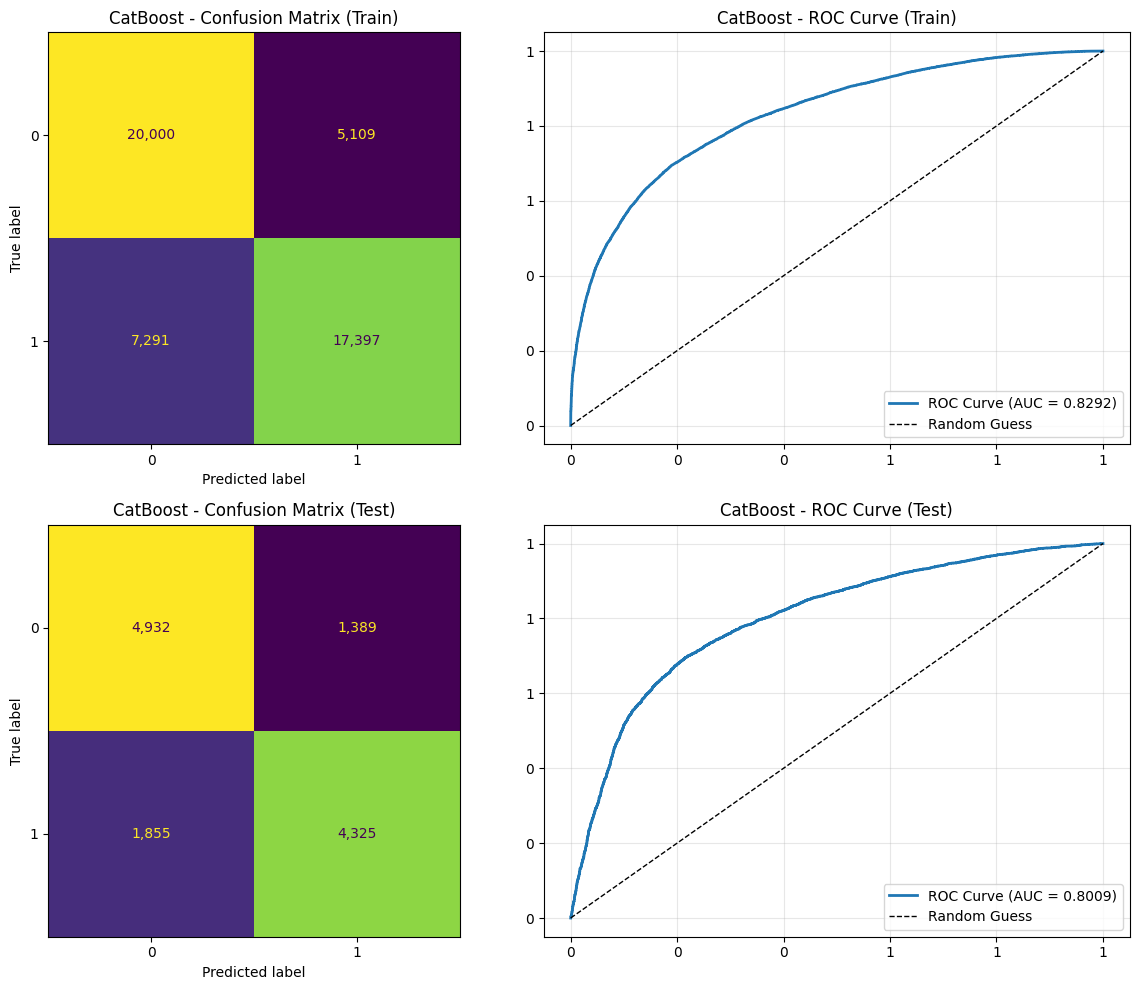

In [10]:
algorithm_name = 'CatBoost'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = catb_model.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = catb_model.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = catb_model.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = catb_model.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [11]:
# best_params = {
#     'max_iter': 409, 
#     'learning_rate': 0.01947652219796748, 
#     'max_leaf_nodes': 36, 
#     'min_samples_leaf': 28, 
#     'l2_regularization': 4.313378648780895e-06, 
#     'random_state': 8404
#             }

hgrb_model =  HistGradientBoostingClassifier(random_state=42)
hgrb_results = evaluate_model(
    model= hgrb_model, 
    model_name="Hist Gradient Boosting", 
    framework="ml",
    x_train=x_train_np, 
    y_train=y_train, 
    x_test=x_test_np, 
    y_test=y_test
)

hgrb_results;


=== Hist Gradient Boosting ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 74.07%     |      0.8017 |
+-------+------------+-------------+
| Train | 73.74%     |      0.8084 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.740741
Test AUC: 0.801717

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7279    0.7782    0.7522      6321
           1     0.7559    0.7024    0.7282      6180

    accuracy                         0.7407     12501
   macro avg     0.7419    0.7403    0.7402     12501
weighted avg     0.7417    0.7407    0.7403     12501


Train Accuracy: 0.737425
Train AUC: 0.808362

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7237    0.7786    0.7501     25313
           1     0.7538    0.6952    0.7233     24688

    accuracy                         0.7374     50001
   macro avg     0.7388    0.7369    0.7367     50001
weighted avg     0.7386    0.7374    0.7369     50001

No significant signs of overfitting.



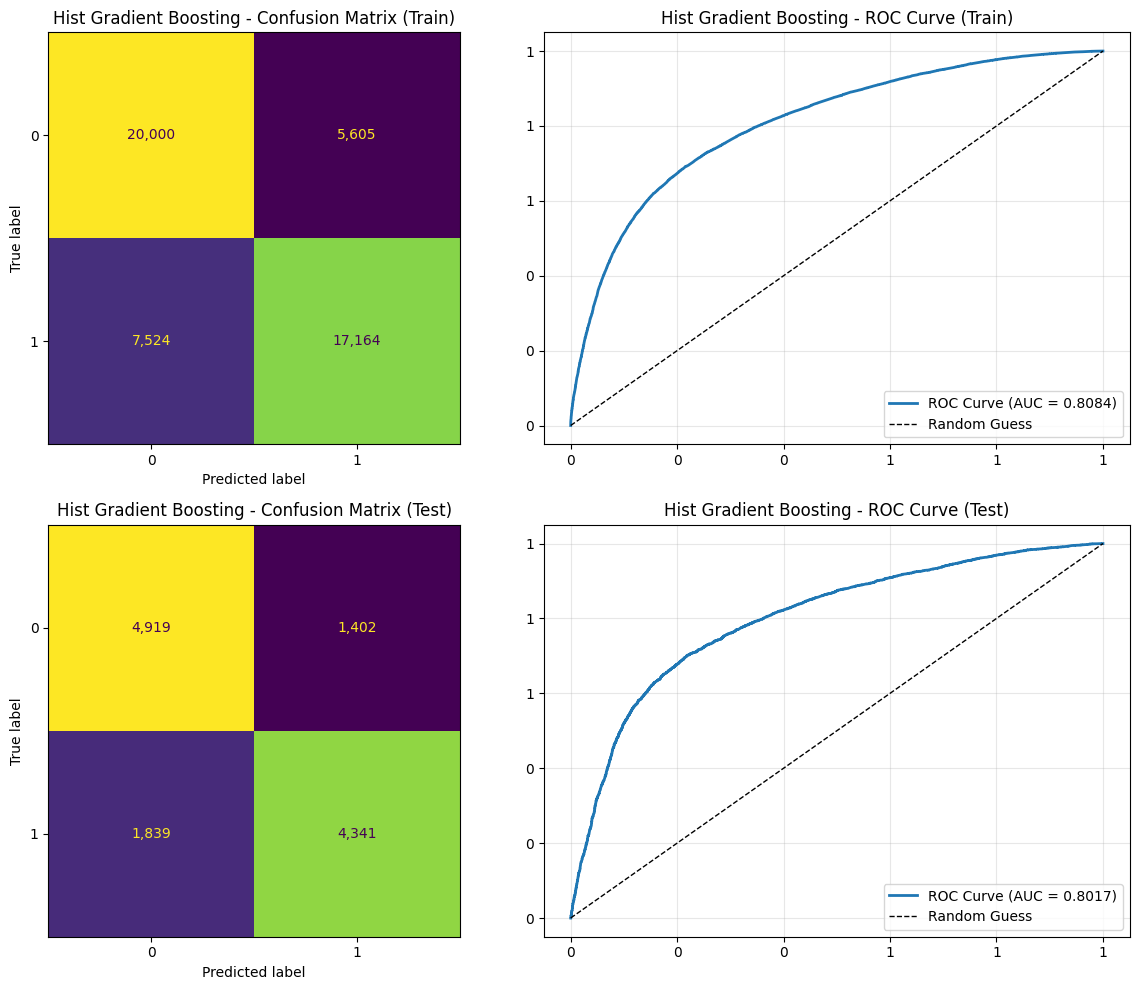

In [12]:
algorithm_name = 'Hist Gradient Boosting'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = hgrb_model.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = hgrb_model.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = hgrb_model.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = hgrb_model.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [13]:
# best_params = {'n_estimators': 478, 'learning_rate': 0.17278746878628695, 'random_state': 5660}

adb_model = AdaBoostClassifier()

adb_results = evaluate_model(
    model= adb_model, 
    model_name="AdaBoost", 
    framework="ml",
    x_train=x_train_np, 
    y_train=y_train, 
    x_test=x_test_np, 
    y_test=y_test
)

adb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== AdaBoost ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 73.27%     |      0.7964 |
+-------+------------+-------------+
| Train | 72.44%     |      0.79   |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.732741
Test AUC: 0.796378

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7060    0.8078    0.7535      6321
           1     0.7694    0.6560    0.7082      6180

    accuracy                         0.7327     12501
   macro avg     0.7377    0.7319    0.7308     12501
weighted avg     0.7374    0.7327    0.7311     12501


Train Accuracy: 0.724406
Train AUC: 0.790032

Train Classification Report:
               precision    recall  f1-score   support

           0     0.6976    0.8043    0.7472     25313
           1     0.7620    0.6425    0.6972     24688

    accuracy                         0.7244     50001
   macro avg     0.7298    0.7234    0.7222     50001
weighted avg     0.7294    0.7244    0.7225     50001

No significant signs of overfitting.



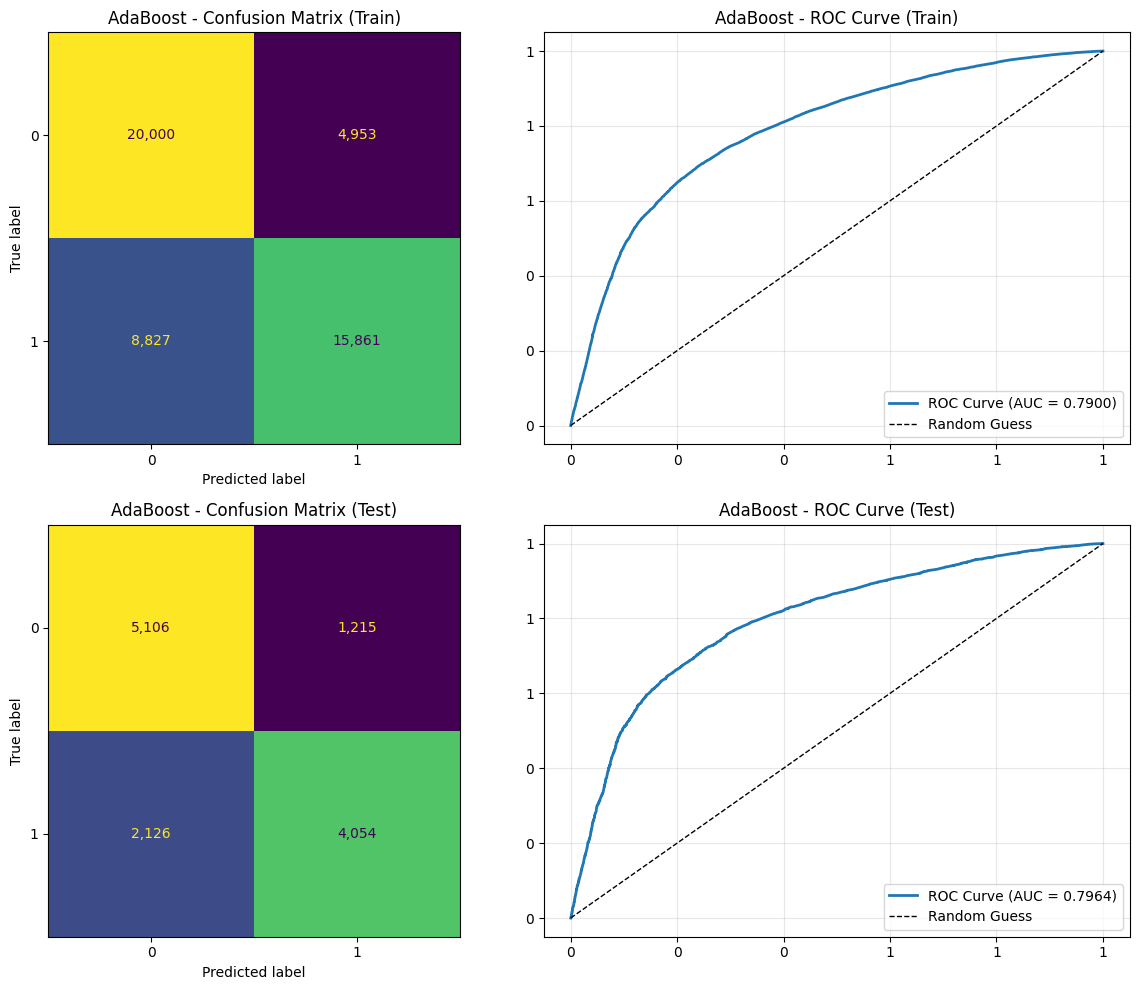

In [14]:
algorithm_name = 'AdaBoost'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = adb_model.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = adb_model.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = adb_model.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = adb_model.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [15]:
tabnet_model = TabNetClassifier(verbose=0)

tabnet_results = evaluate_model(
    model= tabnet_model, 
    model_name="TabNet", 
    framework="tabnet",
    x_train=x_train_np, 
    y_train=y_train, 
    x_test=x_test_np, 
    y_test=y_test
)

tabnet_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)



=== TabNet ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 73.62%     |      0.7994 |
+-------+------------+-------------+
| Train | 73.05%     |      0.7984 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.736261
Test AUC: 0.799427

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7145    0.7969    0.7534      6321
           1     0.7644    0.6743    0.7165      6180

    accuracy                         0.7363     12501
   macro avg     0.7395    0.7356    0.7350     12501
weighted avg     0.7392    0.7363    0.7352     12501


Train Accuracy: 0.730585
Train AUC: 0.798443

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7093    0.7928    0.7487     25313
           1     0.7584    0.6668    0.7096     24688

    accuracy                         0.7306     50001
   macro avg     0.7338    0.7298    0.7292     50001
weighted avg     0.7335    0.7306    0.7294     50001

No significant signs of overfitting.



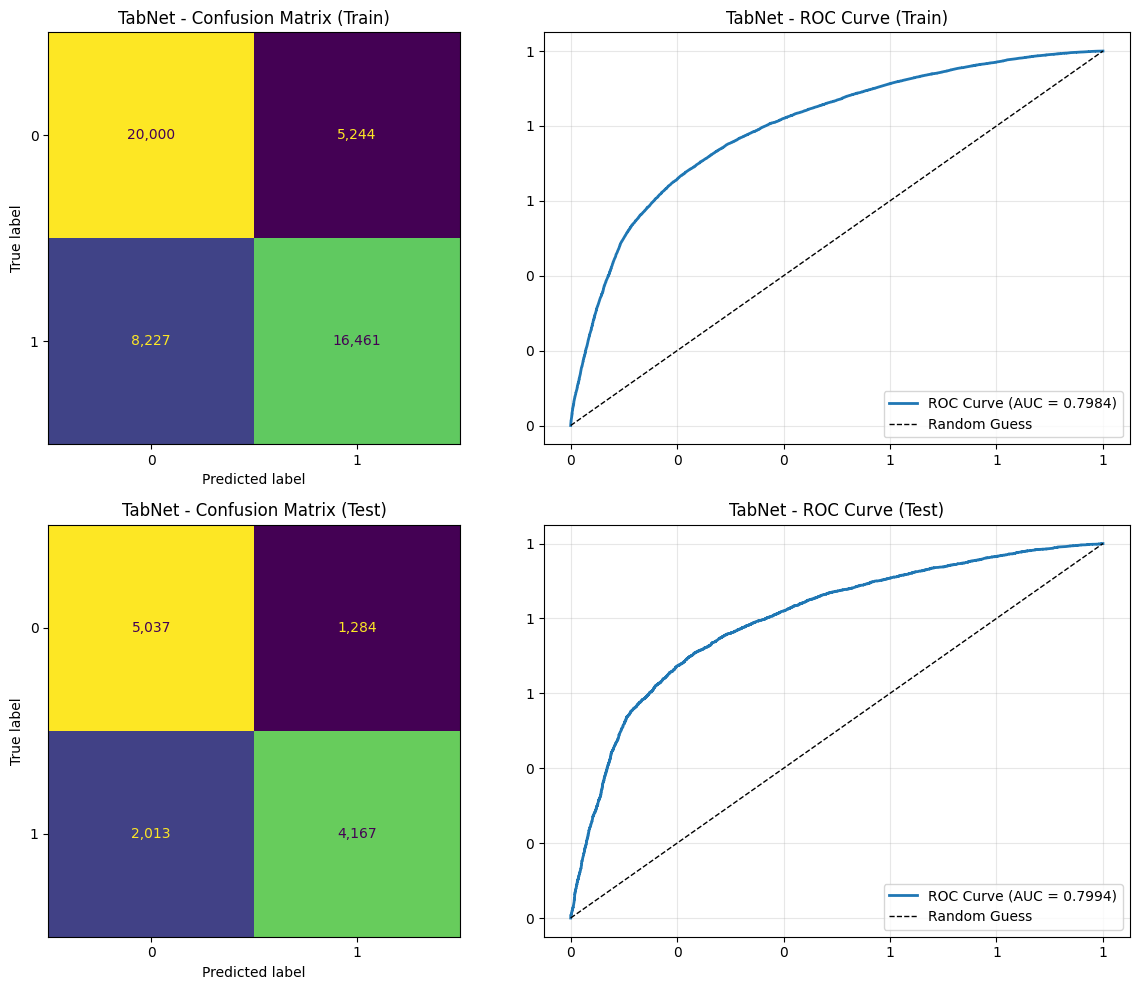

In [16]:
algorithm_name = 'TabNet'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = tabnet_model.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = tabnet_model.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = tabnet_model.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = tabnet_model.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [17]:
continuous_indices = list(range(len(numerical_features)))  
categorical_indices = list(range(len(numerical_features), len(transformed_feature_names)))  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
tabtf_model = TabTransformer(
    categories = (3, 3, 2, 2, 2, 2), 
    num_continuous = len(continuous_indices),
    dim = 32,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.1,
    ff_dropout = 0.1,
    mlp_hidden_mults = (4, 2),
    mlp_act = nn.ReLU(),
    continuous_mean_std = None
).to(device)

tabtf_results = evaluate_model(
    model=tabtf_model, 
    model_name="TabTransformer", 
    framework="tab transformer",
    x_train=x_train_np, 
    y_train=y_train_np, 
    x_test=x_test_np, 
    y_test=y_test_np
)
tabtf_results;

Epoch 1/10, Training Loss: 0.6329
Epoch 2/10, Training Loss: 0.6155
Epoch 3/10, Training Loss: 0.6132
Epoch 4/10, Training Loss: 0.6125
Epoch 5/10, Training Loss: 0.6118
Epoch 6/10, Training Loss: 0.6119
Epoch 7/10, Training Loss: 0.6103
Epoch 8/10, Training Loss: 0.6098
Epoch 9/10, Training Loss: 0.6094
Epoch 10/10, Training Loss: 0.6089

=== TabTransformer ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 68.32%     |      0.7406 |
+-------+------------+-------------+
| Train | 67.14%     |      0.7298 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.683225
Test AUC: 0.740650

Test Classification Report:
               precision    recall  f1-score   support

           0     0.6781    0.7111    0.6942      6321
           1     0.6890    0.6547    0.6714      6180

    accuracy                         0.6832     12501
   macro avg     0.6836    0.6829    0.6828     12501
weighted avg     0.6835    0.6832    0.6829     12501


Train Accuracy: 0.671487
Train AUC: 0.729761

Train Classification Report:
               precision    recall  f1-score   support

           0     0.6679    0.6983    0.6828     25313
           1     0.6755    0.6440    0.6594     24688

    accuracy                         0.6715     50001
   macro avg     0.6717    0.6711    0.6711     50001
weighted avg     0.6717    0.6715    0.6712     50001

No significant signs of overfitting.



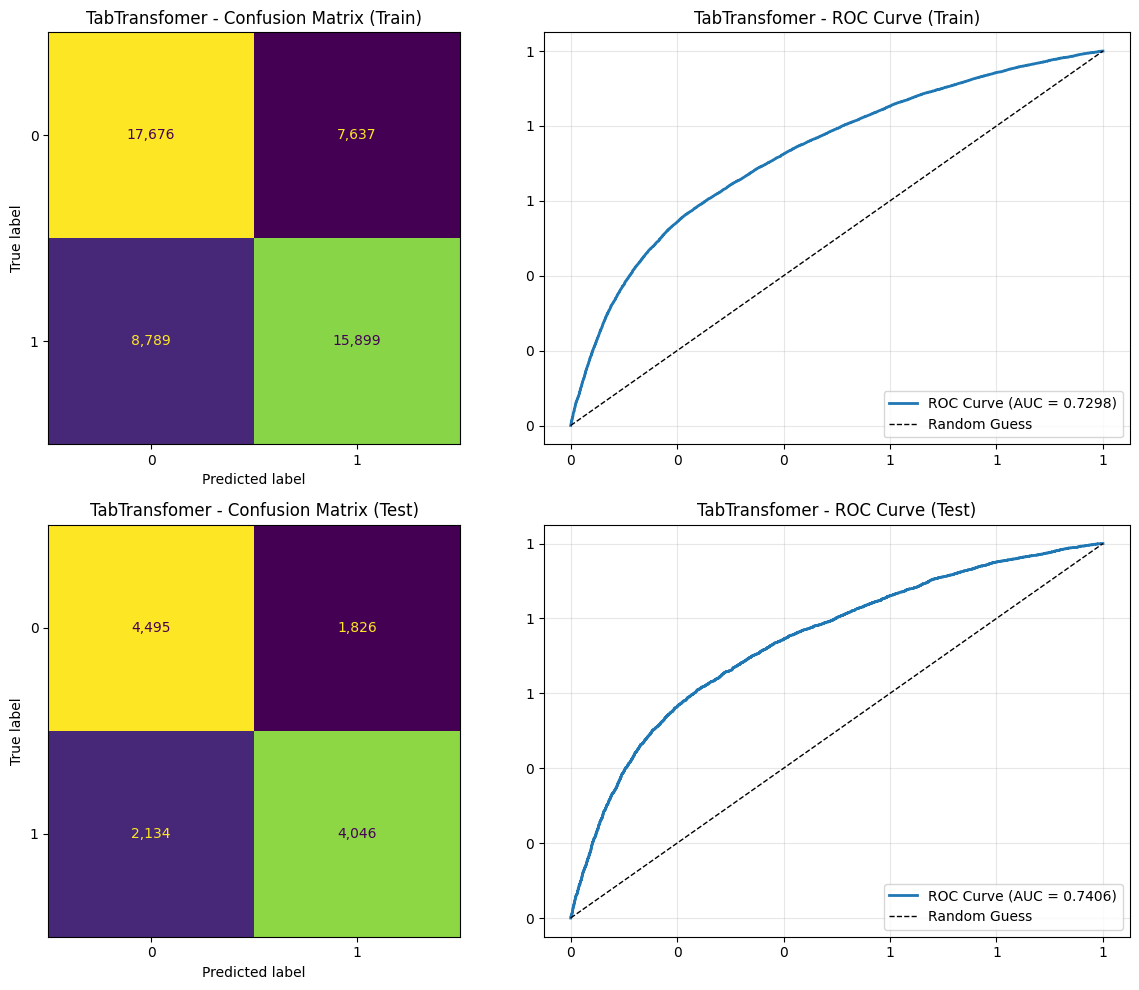

In [19]:
algorithm_name = 'TabTransfomer'

all_indices = np.arange(x_test_np.shape[1])
categorical_indices = np.setdiff1d(all_indices, continuous_indices)

x_cat_test = torch.from_numpy(x_test_np[:, categorical_indices]).long().to(device)
x_cont_test = torch.from_numpy(x_test_np[:, continuous_indices]).float().to(device)

x_cat_train = torch.from_numpy(x_train_np[:, categorical_indices]).long().to(device)
x_cont_train = torch.from_numpy(x_train_np[:, continuous_indices]).float().to(device)

# Pastikan model dalam mode evaluasi
tabtf_model.eval()

# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
with torch.no_grad():
    test_outputs = tabtf_model(x_cat_test, x_cont_test).squeeze(-1)
    test_pred_prob = torch.sigmoid(test_outputs).cpu().numpy()
y_pred_test = (test_pred_prob >= 0.5).astype(int)

accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
with torch.no_grad():
    train_outputs = tabtf_model(x_cat_train, x_cont_train).squeeze(-1)
    train_pred_prob = torch.sigmoid(train_outputs).cpu().numpy()
y_pred_train = (train_pred_prob >= 0.5).astype(int)

accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

# Confusion Matrix (Train)
cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

# ROC Curve (Train)
fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

# Confusion Matrix (Test)
cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

# ROC Curve (Test)
fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [20]:
wrapped_tabtf = PyTorchClassifier(
    model=tabtf_model,
    epochs=10,
    lr=1e-3,
    batch_size=32,
    continuous_indices=list(range(len(numerical_features))),
    categorical_indices=list(range(len(numerical_features), len(transformed_feature_names)))
)


In [21]:
fttf_model = FTTransformer(
    categories = (3, 3, 2, 2, 2, 2), 
    num_continuous = len(continuous_indices),
    dim = 32,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.1,
    ff_dropout = 0.1
).to(device)

fttf_results = evaluate_model(
    model=fttf_model, 
    model_name="TabTransformer", 
    framework="tab transformer",
    x_train=x_train_np, 
    y_train=y_train_np, 
    x_test=x_test_np, 
    y_test=y_test_np
)
fttf_results;

Epoch 1/10, Training Loss: 0.5598
Epoch 2/10, Training Loss: 0.5545
Epoch 3/10, Training Loss: 0.5523
Epoch 4/10, Training Loss: 0.5510
Epoch 5/10, Training Loss: 0.5506
Epoch 6/10, Training Loss: 0.5508
Epoch 7/10, Training Loss: 0.5500
Epoch 8/10, Training Loss: 0.5501
Epoch 9/10, Training Loss: 0.5486
Epoch 10/10, Training Loss: 0.5485

=== TabTransformer ===

+-------+------------+-------------+
|       | Accuracy   |   AUC Score |
+=======+============+=============+
| Test  | 73.84%     |      0.8017 |
+-------+------------+-------------+
| Train | 72.98%     |      0.7972 |
+-------+------------+-------------+

Overfitting Check :
No significant signs of overfitting.



Test Accuracy: 0.738421
Test AUC: 0.801731

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7125    0.8092    0.7578      6321
           1     0.7734    0.6660    0.7157      6180

    accuracy                         0.7384     12501
   macro avg     0.7429    0.7376    0.7367     12501
weighted avg     0.7426    0.7384    0.7370     12501


Train Accuracy: 0.729805
Train AUC: 0.797166

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7028    0.8079    0.7517     25313
           1     0.7674    0.6497    0.7037     24688

    accuracy                         0.7298     50001
   macro avg     0.7351    0.7288    0.7277     50001
weighted avg     0.7347    0.7298    0.7280     50001

No significant signs of overfitting.



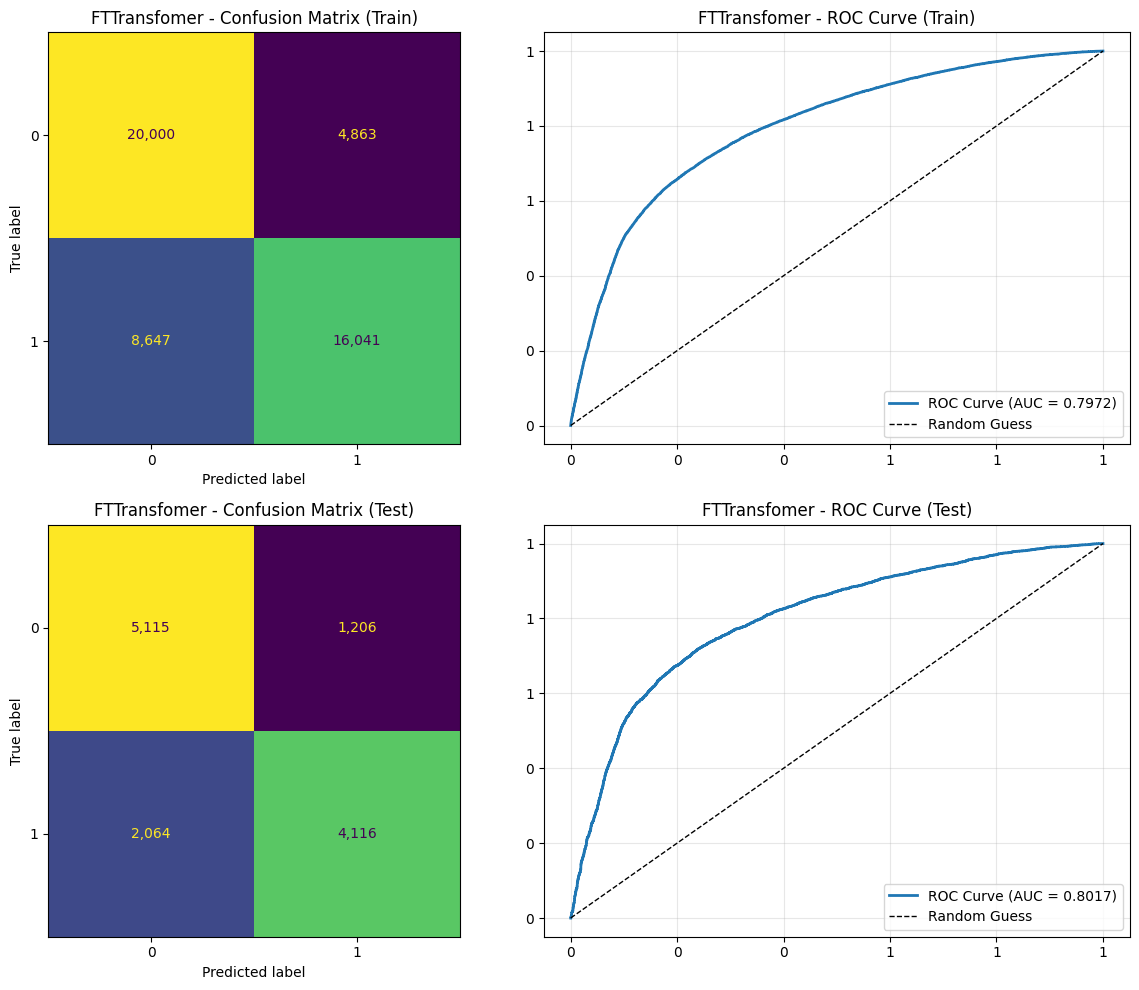

In [22]:
algorithm_name = 'FTTransfomer'

all_indices = np.arange(x_test_np.shape[1])
categorical_indices = np.setdiff1d(all_indices, continuous_indices)

x_cat_test = torch.from_numpy(x_test_np[:, categorical_indices]).long().to(device)
x_cont_test = torch.from_numpy(x_test_np[:, continuous_indices]).float().to(device)

x_cat_train = torch.from_numpy(x_train_np[:, categorical_indices]).long().to(device)
x_cont_train = torch.from_numpy(x_train_np[:, continuous_indices]).float().to(device)

# Pastikan model dalam mode evaluasi
fttf_model.eval()

# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
with torch.no_grad():
    test_outputs = fttf_model(x_cat_test, x_cont_test).squeeze(-1)
    test_pred_prob = torch.sigmoid(test_outputs).cpu().numpy()
y_pred_test = (test_pred_prob >= 0.5).astype(int)

accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
with torch.no_grad():
    train_outputs = fttf_model(x_cat_train, x_cont_train).squeeze(-1)
    train_pred_prob = torch.sigmoid(train_outputs).cpu().numpy()
y_pred_train = (train_pred_prob >= 0.5).astype(int)

accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

# Confusion Matrix (Train)
cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

# ROC Curve (Train)
fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

# Confusion Matrix (Test)
cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

# ROC Curve (Test)
fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [23]:
wrapped_fttf = PyTorchClassifier(
    model=fttf_model,
    epochs=10,
    lr=1e-3,
    batch_size=32,
    continuous_indices=list(range(len(numerical_features))),
    categorical_indices=list(range(len(numerical_features), len(transformed_feature_names)))
)


In [24]:
base_models_ml = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model)
]

base_models_dl = [
    ('tabnet', tabnet_model),
    ('tabtf', wrapped_tabtf),
    ('fttf', wrapped_fttf)
]

base_models_el = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model),
    ('tabnet', tabnet_model),
    ('tabtf', wrapped_tabtf),
    ('fttf', wrapped_fttf)
]

In [25]:
meta_model = adb_model

In [26]:
stacking_model_ml = StackingClassifier(estimators=base_models_ml,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_dl = StackingClassifier(estimators=base_models_dl,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_el = StackingClassifier(estimators=base_models_el,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

In [27]:
stacking_model_ml.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7177a511e380>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)

Test Accuracy: 0.737941
Test AUC: 0.800816

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7044    0.8301    0.7621      6321
           1     0.7874    0.6437    0.7083      6180

    accuracy                         0.7379     12501
   macro avg     0.7459    0.7369    0.7352     12501
weighted avg     0.7454    0.7379    0.7355     12501


Train Accuracy: 0.734705
Train AUC: 0.814085

Train Classification Report:
               precision    recall  f1-score   support

           0     0.6995    0.8343    0.7610     25313
           1     0.7883    0.6326    0.7019     24688

    accuracy                         0.7347     50001
   macro avg     0.7439    0.7334    0.7315     50001
weighted avg     0.7434    0.7347    0.7318     50001

No significant signs of overfitting.



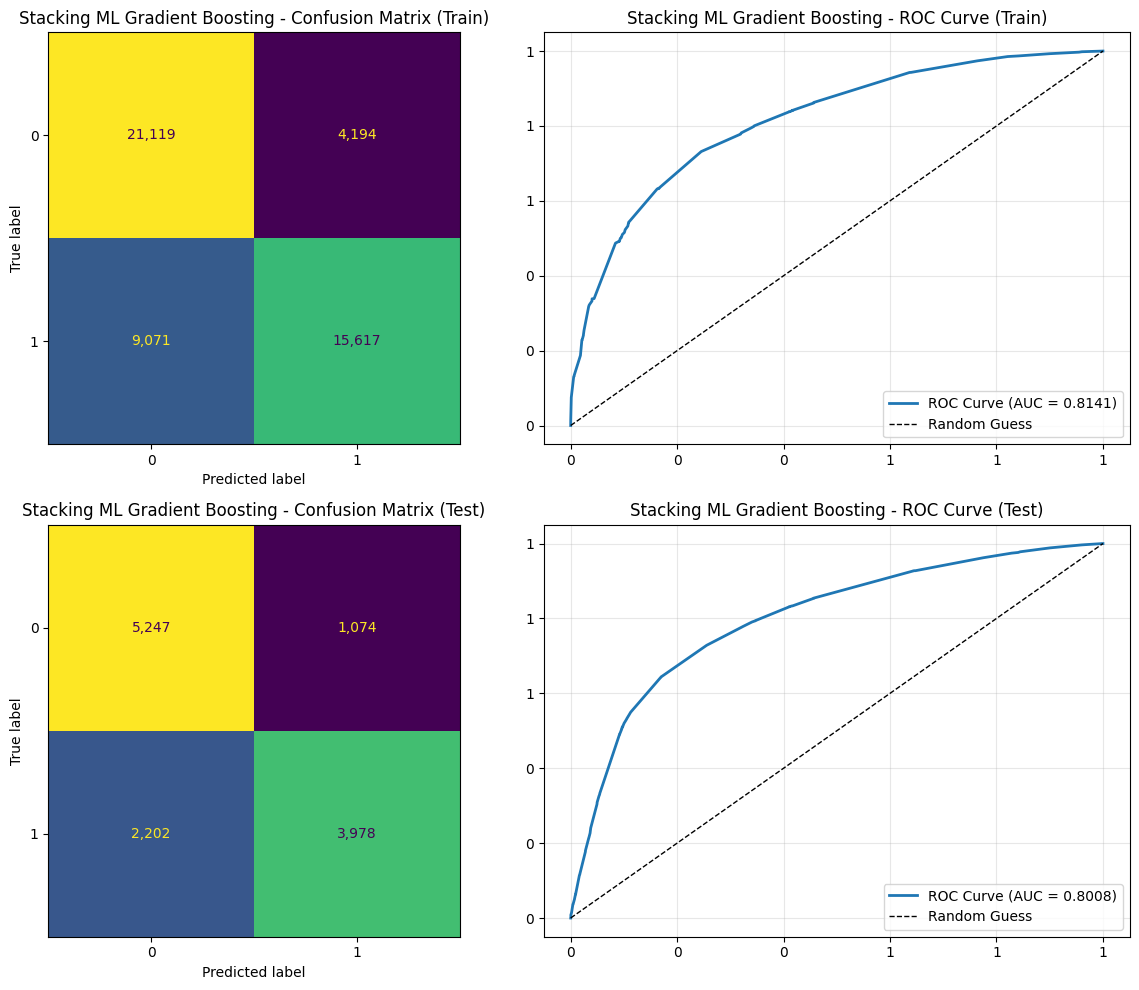

In [28]:
algorithm_name = 'Stacking ML Gradient Boosting'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = stacking_model_ml.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = stacking_model_ml.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.6f}")
print("Test AUC:", f"{auc_test:.6f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = stacking_model_ml.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = stacking_model_ml.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.6f}")
print("Train AUC:", f"{auc_train:.6f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None

cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

for ax in axes.flat:
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

for ax in [axes[0, 0], axes[1, 0]]:
    for text in ax.texts:
        try:
            val = float(text.get_text())
            text.set_text(f"{val:,.0f}")
        except ValueError:
            continue

plt.tight_layout()
plt.show()

In [29]:
stacking_model_dl.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.6083
[Wrapper] Epoch 2/10, Loss: 0.6083
[Wrapper] Epoch 3/10, Loss: 0.6079
[Wrapper] Epoch 4/10, Loss: 0.6072
[Wrapper] Epoch 5/10, Loss: 0.6068
[Wrapper] Epoch 6/10, Loss: 0.6076
[Wrapper] Epoch 7/10, Loss: 0.6077
[Wrapper] Epoch 8/10, Loss: 0.6056
[Wrapper] Epoch 9/10, Loss: 0.6060
[Wrapper] Epoch 10/10, Loss: 0.6061
[Wrapper] Epoch 1/10, Loss: 0.5492
[Wrapper] Epoch 2/10, Loss: 0.5491
[Wrapper] Epoch 3/10, Loss: 0.5482
[Wrapper] Epoch 4/10, Loss: 0.5480
[Wrapper] Epoch 5/10, Loss: 0.5476
[Wrapper] Epoch 6/10, Loss: 0.5476
[Wrapper] Epoch 7/10, Loss: 0.5480
[Wrapper] Epoch 8/10, Loss: 0.5473
[Wrapper] Epoch 9/10, Loss: 0.5473
[Wrapper] Epoch 10/10, Loss: 0.5473


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.6077
[Wrapper] Epoch 2/10, Loss: 0.6077
[Wrapper] Epoch 3/10, Loss: 0.6066
[Wrapper] Epoch 4/10, Loss: 0.6066
[Wrapper] Epoch 5/10, Loss: 0.6060
[Wrapper] Epoch 6/10, Loss: 0.6056
[Wrapper] Epoch 7/10, Loss: 0.6057
[Wrapper] Epoch 8/10, Loss: 0.6052
[Wrapper] Epoch 9/10, Loss: 0.6044
[Wrapper] Epoch 10/10, Loss: 0.6037
[Wrapper] Epoch 1/10, Loss: 0.6093
[Wrapper] Epoch 2/10, Loss: 0.6083
[Wrapper] Epoch 3/10, Loss: 0.6097
[Wrapper] Epoch 4/10, Loss: 0.6089
[Wrapper] Epoch 5/10, Loss: 0.6084
[Wrapper] Epoch 6/10, Loss: 0.6071
[Wrapper] Epoch 7/10, Loss: 0.6078
[Wrapper] Epoch 8/10, Loss: 0.6071
[Wrapper] Epoch 9/10, Loss: 0.6066
[Wrapper] Epoch 10/10, Loss: 0.6055
[Wrapper] Epoch 1/10, Loss: 0.6091
[Wrapper] Epoch 2/10, Loss: 0.6094
[Wrapper] Epoch 3/10, Loss: 0.6082
[Wrapper] Epoch 4/10, Loss: 0.6076
[Wrapper] Epoch 5/10, Loss: 0.6070
[Wrapper] Epoch 6/10, Loss: 0.6080
[Wrapper] Epoch 7/10, Loss: 0.6069
[Wrapper] Epoch 8/10, Loss: 0.6059
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lambda_sparse=0.001,
                                                 seed=0,
                                                 clip_value=1,
                                                 verbose=0,
                                                 optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                                 optimizer_params={'lr': 0.02},
                                                 scheduler_fn=None,
                                                 scheduler_params={},...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)

In [30]:
y_pred = stacking_model_dl.predict(x_test_np)

accuracy = accuracy_score(y_test_np, y_pred)
report = classification_report(y_test_np, y_pred, digits=4)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)


Accuracy: 0.7389808815294776

Classification Report:
               precision    recall  f1-score   support

           0     0.7184    0.7956    0.7550      6321
           1     0.7651    0.6811    0.7207      6180

    accuracy                         0.7390     12501
   macro avg     0.7418    0.7383    0.7379     12501
weighted avg     0.7415    0.7390    0.7380     12501



In [31]:
stacking_model_el.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.6083
[Wrapper] Epoch 2/10, Loss: 0.6083
[Wrapper] Epoch 3/10, Loss: 0.6079
[Wrapper] Epoch 4/10, Loss: 0.6072
[Wrapper] Epoch 5/10, Loss: 0.6068
[Wrapper] Epoch 6/10, Loss: 0.6076
[Wrapper] Epoch 7/10, Loss: 0.6077
[Wrapper] Epoch 8/10, Loss: 0.6056
[Wrapper] Epoch 9/10, Loss: 0.6060
[Wrapper] Epoch 10/10, Loss: 0.6061
[Wrapper] Epoch 1/10, Loss: 0.5492
[Wrapper] Epoch 2/10, Loss: 0.5491
[Wrapper] Epoch 3/10, Loss: 0.5482
[Wrapper] Epoch 4/10, Loss: 0.5480
[Wrapper] Epoch 5/10, Loss: 0.5476
[Wrapper] Epoch 6/10, Loss: 0.5476
[Wrapper] Epoch 7/10, Loss: 0.5480
[Wrapper] Epoch 8/10, Loss: 0.5473
[Wrapper] Epoch 9/10, Loss: 0.5473
[Wrapper] Epoch 10/10, Loss: 0.5473


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.6077
[Wrapper] Epoch 2/10, Loss: 0.6077
[Wrapper] Epoch 3/10, Loss: 0.6066
[Wrapper] Epoch 4/10, Loss: 0.6066
[Wrapper] Epoch 5/10, Loss: 0.6060
[Wrapper] Epoch 6/10, Loss: 0.6056
[Wrapper] Epoch 7/10, Loss: 0.6057
[Wrapper] Epoch 8/10, Loss: 0.6052
[Wrapper] Epoch 9/10, Loss: 0.6044
[Wrapper] Epoch 10/10, Loss: 0.6037
[Wrapper] Epoch 1/10, Loss: 0.6093
[Wrapper] Epoch 2/10, Loss: 0.6083
[Wrapper] Epoch 3/10, Loss: 0.6097
[Wrapper] Epoch 4/10, Loss: 0.6089
[Wrapper] Epoch 5/10, Loss: 0.6084
[Wrapper] Epoch 6/10, Loss: 0.6071
[Wrapper] Epoch 7/10, Loss: 0.6078
[Wrapper] Epoch 8/10, Loss: 0.6071
[Wrapper] Epoch 9/10, Loss: 0.6066
[Wrapper] Epoch 10/10, Loss: 0.6055
[Wrapper] Epoch 1/10, Loss: 0.6091
[Wrapper] Epoch 2/10, Loss: 0.6094
[Wrapper] Epoch 3/10, Loss: 0.6082
[Wrapper] Epoch 4/10, Loss: 0.6076
[Wrapper] Epoch 5/10, Loss: 0.6070
[Wrapper] Epoch 6/10, Loss: 0.6080
[Wrapper] Epoch 7/10, Loss: 0.6069
[Wrapper] Epoch 8/10, Loss: 0.6059
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7177a511e380>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42)),
                               ('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lam...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)

Test Accuracy: 0.7401
Test AUC: 0.8020

Test Classification Report:
               precision    recall  f1-score   support

           0     0.7181    0.8002    0.7569      6321
           1     0.7686    0.6786    0.7208      6180

    accuracy                         0.7401     12501
   macro avg     0.7433    0.7394    0.7389     12501
weighted avg     0.7430    0.7401    0.7391     12501


Train Accuracy: 0.7330
Train AUC: 0.8088

Train Classification Report:
               precision    recall  f1-score   support

           0     0.7096    0.7999    0.7521     25313
           1     0.7640    0.6645    0.7108     24688

    accuracy                         0.7330     50001
   macro avg     0.7368    0.7322    0.7314     50001
weighted avg     0.7365    0.7330    0.7317     50001

No significant signs of overfitting.



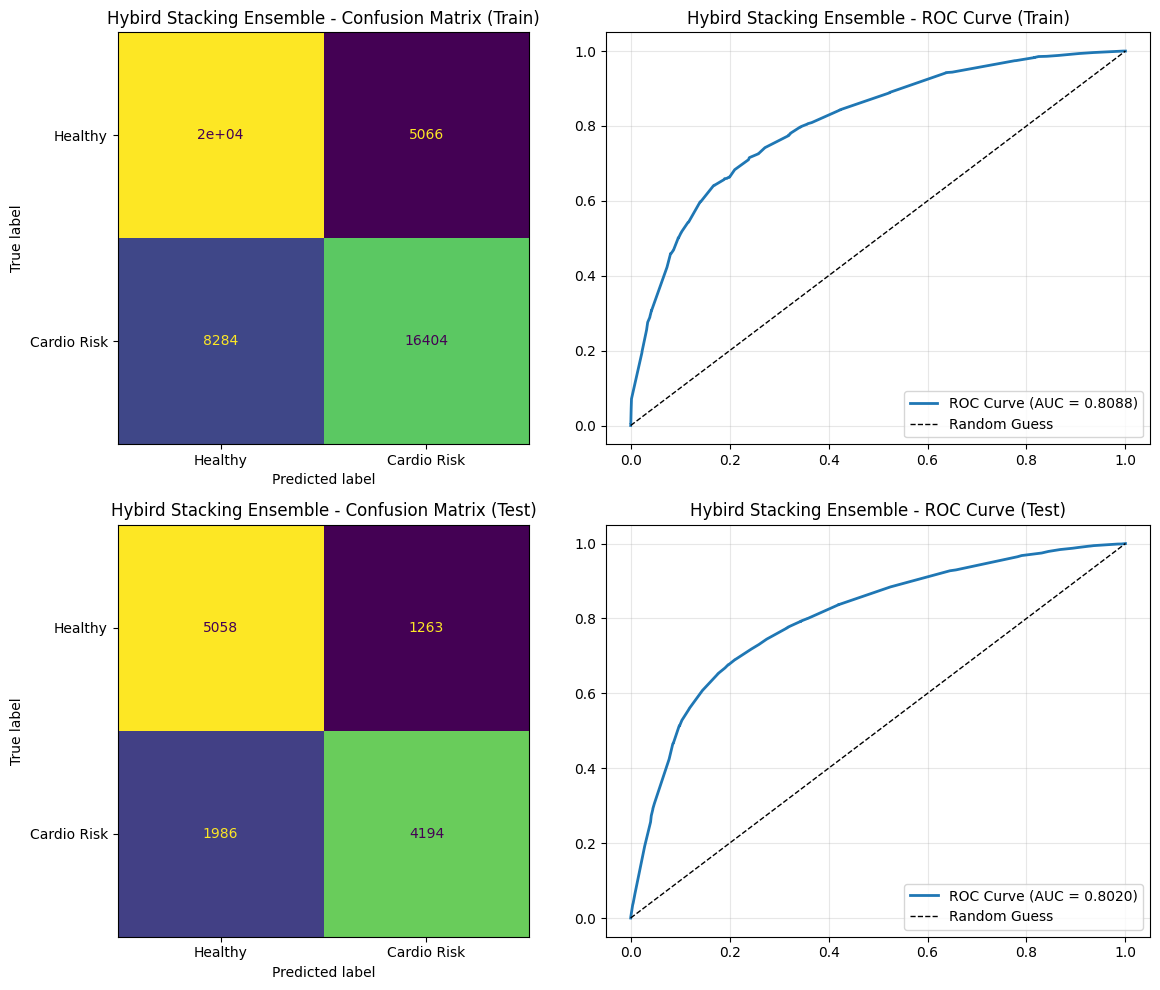

In [32]:
algorithm_name = 'Hybird Stacking Ensemble'
# ------------------------------
# Evaluasi Data Uji (Test)
# ------------------------------
y_pred_test = stacking_model_el.predict(x_test_np)
accuracy_test = accuracy_score(y_test_np, y_pred_test)
report_test = classification_report(y_test_np, y_pred_test, digits=4)

test_pred_prob = stacking_model_el.predict_proba(x_test_np)[:, 1]
auc_test = roc_auc_score(y_test_np, test_pred_prob)

print("Test Accuracy:", f"{accuracy_test:.4f}")
print("Test AUC:", f"{auc_test:.4f}")
print("\nTest Classification Report:\n", report_test)

# ------------------------------
# Evaluasi Data Latih (Train)
# ------------------------------
y_pred_train = stacking_model_el.predict(x_train_np)
accuracy_train = accuracy_score(y_train_np, y_pred_train)
report_train = classification_report(y_train_np, y_pred_train, digits=4)

train_pred_prob = stacking_model_el.predict_proba(x_train_np)[:, 1]
auc_train = roc_auc_score(y_train_np, train_pred_prob)

print("\nTrain Accuracy:", f"{accuracy_train:.4f}")
print("Train AUC:", f"{auc_train:.4f}")
print("\nTrain Classification Report:\n", report_train)

if accuracy_train > accuracy_test + 0.05 or auc_train > auc_test + 0.05:
    print("The model might be overfitting.")
else:
    print("No significant signs of overfitting.\n")

# ------------------------------
# Visualisasi Evaluasi (Train & Test)
# ------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
display_labels = list(label_mapping.values()) if 'label_mapping' in globals() else None


cm_train = confusion_matrix(y_train_np, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=display_labels)
disp_train.plot(ax=axes[0, 0], cmap='viridis', colorbar=False)
axes[0, 0].set_title(f"{algorithm_name} - Confusion Matrix (Train)")

fpr_train, tpr_train, _ = roc_curve(y_train_np, train_pred_prob)
axes[0, 1].plot(fpr_train, tpr_train, label=f"ROC Curve (AUC = {auc_train:.4f})", linewidth=2)
axes[0, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[0, 1].set_title(f"{algorithm_name} - ROC Curve (Train)")
axes[0, 1].legend(loc="lower right")
axes[0, 1].grid(alpha=0.3)

cm_test = confusion_matrix(y_test_np, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=display_labels)
disp_test.plot(ax=axes[1, 0], cmap='viridis', colorbar=False)
axes[1, 0].set_title(f"{algorithm_name} - Confusion Matrix (Test)")

fpr_test, tpr_test, _ = roc_curve(y_test_np, test_pred_prob)
axes[1, 1].plot(fpr_test, tpr_test, label=f"ROC Curve (AUC = {auc_test:.4f})", linewidth=2)
axes[1, 1].plot([0, 1], [0, 1], 'k--', label="Random Guess", linewidth=1)
axes[1, 1].set_title(f"{algorithm_name} - ROC Curve (Test)")
axes[1, 1].legend(loc="lower right")
axes[1, 1].grid(alpha=0.3)

plt.ticklabel_format(style='plain', axis='both', useOffset=False)
plt.tight_layout()
plt.show()

In [33]:
# import numpy as np
# from scipy.stats import pearsonr

# # Misal, prediksi probabilitas dari base model disimpan dalam dictionary
# # Prediksi base model harus berupa array 1 dimensi (misalnya, probabilitas kelas positif)
# preds_lgbm = lgbm_model.predict_proba(x_test_np)[:, 1]
# preds_cat = catb_model.predict_proba(x_test_np)[:, 1]
# preds_hgrb = hgrb_model.predict_proba(x_test_np)[:, 1]
# preds_tabnet = tabnet_model.predict_proba(x_test_np)[:, 1]

# # Menyimpan semua prediksi di dalam array
# all_preds = np.vstack([preds_lgbm, preds_cat, preds_hgrb, preds_tabnet])

# # Menghitung korelasi antar model
# n_models = all_preds.shape[0]
# for i in range(n_models):
#     for j in range(i+1, n_models):
#         corr_coef, _ = pearsonr(all_preds[i], all_preds[j])
#         print(f"Korelasi antara model {i} dan model {j}: {corr_coef:.3f}")


In [34]:
# numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 'map', 'pulse_pressure']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ],
#     remainder='passthrough' 
# )

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', stacking_model)
# ])

# pipeline.fit(X_train, y_train)

# with open("pkl/ml_ensemble_model.pkl", "wb") as f:
#     pickle.dump(pipeline, f)

# print("Pipeline telah disimpan dalam file 'ml_ensemble_model_v2.pkl'.")

In [35]:
# with open('pkl/ml_ensemble_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Lakukan prediksi menggunakan CPU
# y_pred = loaded_model.predict(X_test)

# # Menghitung dan menampilkan accuracy score
# acc = accuracy_score(y_test, y_pred)
# print("Akurasi model:", acc)

In [36]:
# data_new = {
#     'age':       [30, 35, 40, 45, 50, 60, 65, 70, 55, 68],   
#     'height':    [175, 180, 170, 165, 160, 158, 155, 150, 165, 160], 
#     'weight':    [68, 75, 72, 80, 85, 90, 95, 100, 78, 82], 
#     'systolic':  [110, 115, 120, 125, 130, 140, 150, 160, 115, 135],  
#     'diastolic': [70, 75, 80, 85, 90, 95, 100, 105, 75, 88],         
#     'gender':       [0, 0, 1, 0, 1, 1, 1, 1, 0, 1], # gender: 0 untuk nilai asli 1, 1 untuk nilai asli 2
#     'cholesterol':  [0, 0, 1, 1, 2, 2, 2, 2, 0, 2], # cholesterol: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'gluc':         [0, 0, 1, 1, 1, 2, 2, 2, 0, 2], # gluc: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'smoke':        [0, 0, 0, 0, 1, 1, 1, 1, 0, 1],
#     'alco':         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
#     'active':       [1, 1, 1, 1, 0, 0, 0, 0, 1, 0]
# }

# new_df = pd.DataFrame(data_new)

# valid_gender      = new_df['gender'].isin([0, 1])
# valid_cholesterol = new_df['cholesterol'].isin([0, 1, 2])
# valid_gluc        = new_df['gluc'].isin([0, 1, 2])
# valid_smoke       = new_df['smoke'].isin([0, 1])
# valid_alco        = new_df['alco'].isin([0, 1])
# valid_active      = new_df['active'].isin([0, 1])

# if not (valid_gender.all() and valid_cholesterol.all() and valid_gluc.all() and 
#         valid_smoke.all() and valid_alco.all() and valid_active.all()):
#     raise ValueError("Terdapat nilai kategori yang tidak valid pada input data.")

# new_df["bmi"] = round(new_df["weight"] / ((new_df["height"] / 100) ** 2), 2)
# new_df["map"] = round((new_df["systolic"] + 2 * new_df["diastolic"]) / 3, 2)
# new_df["pulse_pressure"] = new_df["systolic"] - new_df["diastolic"]

# expected_order = [
#     'age', 'height', 'weight', 'systolic', 'diastolic', 
#     'bmi', 'map', 'pulse_pressure',
#     'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'
# ]
# new_df = new_df[expected_order]

# with open("pkl/ml_ensemble_model.pkl", "rb") as f:
#     pipeline = pickle.load(f)

# predictions = pipeline.predict(new_df)

# print("Input Data Baru (setelah pembuatan fitur turunan dan validasi):")
# print(new_df)
# print("\nHasil Prediksi untuk 10 contoh data:")
# print("Prediksi status cardio untuk data baru:", predictions)


In [37]:
# stacking_results = evaluate_model(stacking_model, x_train_np, y_train, x_test_np, y_test, "Stacking Ensemble Classifier")
# stacking_results;

In [38]:
# results = [lgbm_results, xgb_results, catb_results, 
#         snb_results, grb_results, hgrb_results, stacking_results
#         ]

# create_summary_table(results)